In [64]:
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
%matplotlib inline

from ray import tune
import ray

In [65]:
#ray.shutdown()
#ray.init()
filename = "./data/wine.csv"
df = pd.read_csv(filename)
df = df.drop('index', axis=1)
print(df.shape)
print(df["quality"].value_counts())

(6497, 12)
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64


In [66]:
from sklearn.utils import resample

#Resample:
df_majority = df[df['quality'] == 6]
for i in range(3,10):
    majority_len = df[df['quality'] == 6].shape[0]
    if i != 6:
        minority_len = df[df['quality'] == i].shape[0]

        df_minority = df[df['quality'] == i]

        df_minority_upsampled = resample(df_minority, 
                                        replace=True,               
                                        n_samples=majority_len,
                                        random_state=123)

        df_majority = df_majority.append(df_minority_upsampled)
df = df_majority
print(df.shape)
print(df["quality"].value_counts())
df = df.sample(frac=1).reset_index(drop=True)

(19852, 12)
3    2836
4    2836
5    2836
6    2836
7    2836
8    2836
9    2836
Name: quality, dtype: int64


In [67]:
train_test_split_fraction = 0.80
split_index = int(df.shape[0] * train_test_split_fraction)
df_train = df[:split_index]
df_test = df[split_index:]

target = pd.get_dummies(df['quality']).values

X_train = df_train.drop('quality', axis = 1).values
X_test = df_test.drop('quality', axis = 1).values

y_train = target[:split_index]
y_test = target[split_index:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15881, 11)
(3971, 11)
(15881, 7)
(3971, 7)


In [68]:
X_train = torch.tensor(X_train, dtype=torch.float64)
y_train = torch.tensor(y_train, dtype=torch.float64)
X_test = torch.tensor(X_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)

In [69]:
#nb_hidden_neurons = 200
nb_classes = len(pd.unique(df['quality']))
nb_classes

7

In [70]:
import torch.nn as nn

class Network(nn.Module):

    def __init__(self, nb_features, nb_hidden_neurons):
        """Here we define the layers
        """

        super().__init__()
        
        self.layer_1 =  nn.Linear(nb_features, nb_hidden_neurons)
        self.hidden_layers =  nn.Linear(nb_hidden_neurons, nb_hidden_neurons)
        self.layer_out =  nn.Linear(nb_hidden_neurons, nb_classes)
        
        

    def forward(self,x, nb_hidden_layers, activation_function):
        """Here we combine the layers
        """
        
        activation_first_layer = nn.CELU()
        activation_function = activation_function
        last_layer_activation = nn.Softmax()
        
        output_first_layer = activation_function(self.layer_1(x))
        outut_hidden_layer = activation_function(self.hidden_layers(output_first_layer))
        for i in range(1, nb_hidden_layers):
            outut_hidden_layer = activation_function(self.hidden_layers(outut_hidden_layer))
        
        prediction = last_layer_activation(self.layer_out(outut_hidden_layer))
        return prediction

In [71]:
def test(X, y, config):
    #my_nn = Network(nb_features=X_train.shape[1], nb_hidden_neurons=config['hidden_neuron'])
    correct = 0
    total = 0
    batch_size = config['batch_size']
    with torch.no_grad():
        for idx in range(0, X.shape[0], batch_size):
            
            total += 1
            
            output = my_nn(X.float(), nb_hidden_layers= config['nb_layers'],activation_function= config['activation'])
            
            predicted = torch.max(output, 1)
            
            target_pred = torch.max(y, 1)
            
            if predicted[1][idx] == target_pred[1][idx]:
                correct += 1
            
    accuracy = correct/total       
    return accuracy

In [72]:
def training(config):
    
    nb_steps_loss_sum = 10
    
    loss_list = []
    running_loss = 0
    batch_nb = 0
    criterion = nn.MSELoss()
    batch_size =  config['batch_size']
    learning_rate = config['lr'] 
    optimizer = torch.optim.AdamW(my_nn.parameters(), lr=learning_rate)

    for epoch in range(0,config['epoch']):
        for idx in range(0, X_train.shape[0], batch_size):
            
            input_batch = X_train[idx:idx + batch_size]
            target = y_train[idx:idx + batch_size]

            optimizer.zero_grad()

            y_pred = my_nn(input_batch.float(),nb_hidden_layers= config['nb_layers'],activation_function= config['activation'])

            loss = criterion(y_pred, target.float())

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            save_loss_condition = batch_nb % nb_steps_loss_sum == (nb_steps_loss_sum - 1)
            
            if save_loss_condition:    
                loss_list.append(running_loss)
                running_loss = 0.0

            batch_nb+= 1
    return loss_list
    #graph_loss = []
    #graph_loss.append(loss_list)
    #tune.report(mean_loss=abs(loss_list[len(loss_list)-1]))

In [73]:
'''search_space = {
    "lr": tune.grid_search([0.001, 0.01]),
    "hidden_neuron": tune.grid_search([50, 100, 200]),
    "epoch": tune.grid_search([20, 30, 60]),
    "batch_size": tune.grid_search([5, 30]),
    "nb_layers": tune.grid_search([5, 6, 7]),
    "activation": tune.grid_search([nn.SiLU()])
}
analysis = tune.run(training, config=search_space)'''

'search_space = {\n    "lr": tune.grid_search([0.001, 0.01]),\n    "hidden_neuron": tune.grid_search([50, 100, 200]),\n    "epoch": tune.grid_search([20, 30, 60]),\n    "batch_size": tune.grid_search([5, 30]),\n    "nb_layers": tune.grid_search([5, 6, 7]),\n    "activation": tune.grid_search([nn.SiLU()])\n}\nanalysis = tune.run(training, config=search_space)'

In [74]:
#best = analysis.get_best_config(metric="mean_loss", mode="min")
#lr: 0.001, hidden_neuron: 200, epoch: 60, batch_size: 30, nblayers: 7, activation SiLU()
#rint(best)

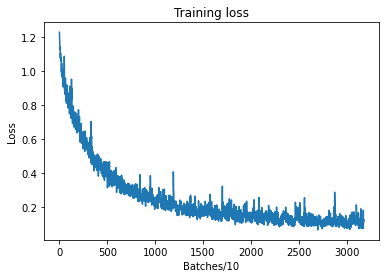

In [75]:
config = {
    'lr' : 0.001,
    'hidden_neuron': 200,
    'epoch': 200,
    'batch_size': 100,
    'nb_layers': 5,
    'activation': nn.SiLU()
}

my_nn = Network(nb_features=X_train.shape[1], nb_hidden_neurons=config['hidden_neuron'])

loss = training(config)
nb_steps_loss_sum = 10
# Plotting the loss over training
plt.figure()
plt.plot(range(0, len(loss)), loss)
plt.xlabel(f"Batches/{nb_steps_loss_sum}")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()
plt.close()

In [76]:
print(test(X_train, y_train, config))
print(test(X_test, y_test, config))

0.9559748427672956
0.95
